# Домашнее задание №4
Рома Казаков

Загружаем датасет и необходимые библиотеки.

In [1]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 51.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 49.1MB/s]


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 7.9 MB/s 
     |████████████████████████████████| 895 kB 35.2 MB/s 
     |████████████████████████████████| 67 kB 4.2 MB/s 
     |████████████████████████████████| 596 kB 37.3 MB/s 
     |████████████████████████████████| 6.5 MB 33.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import warnings
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments, BertModel, BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Данные

In [3]:
df = pd.read_csv("reviews.csv")
df

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo
...,...,...,...,...,...,...,...,...,...,...,...
15741,Tammy Kay,https://lh3.googleusercontent.com/a-/AOh14GhYP...,I believe that this is by far the best app wit...,5,0,NaN,2018-02-17 06:09:03,NaN,NaN,newest,com.appxy.planner
15742,Ysm Johan,https://lh3.googleusercontent.com/a-/AOh14Ggmd...,It sometimes crashes a lot!!,5,0,4.3.7,2018-02-15 10:45:22,NaN,NaN,newest,com.appxy.planner
15743,casey dearden,https://lh3.googleusercontent.com/a-/AOh14Gg2U...,Works well for what I need,5,0,4.3.7,2018-02-09 18:40:37,NaN,NaN,newest,com.appxy.planner
15744,Jerry G Tamate,https://lh3.googleusercontent.com/a-/AOh14GiTP...,Love it.,5,0,NaN,2018-02-06 12:36:17,NaN,NaN,newest,com.appxy.planner


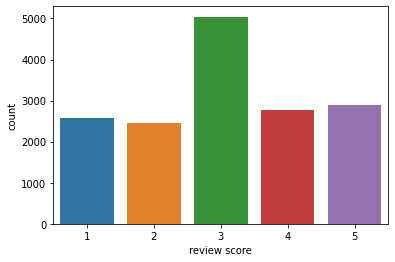

In [4]:
sns.countplot(df.score)
plt.xlabel('review score');

Посмотрев на данные и поняв, что они неравномерны, объединяем классы 1 и 2 в "негативные" отзывы, а 4 и 5 — в "позитивные". 3, соответственно, — нейтральные.

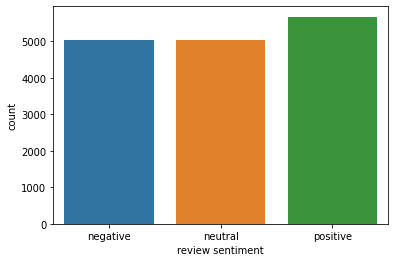

In [5]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

class_names = ['negative', 'neutral', 'positive']

ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Кажется, новое распределение намного лучше.

## Предобработка

Я использовал модель `prajjwal1/bert-tiny` — не самая качественная, но зато компактная и быстрая.

In [6]:
PRE_TRAINED_MODEL_NAME = 'prajjwal1/bert-tiny'
N_CLASSES = len(class_names)

Получаем обучающий, валидационный и тестовый сеты данных.

In [7]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df.content.to_list(), 
                                                                    df.sentiment.to_list(), 
                                                                    test_size=0.1)
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts,
                                                                      train_labels,
                                                                      test_size=0.1)

Инициализируем токенизатор.

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Создаём кастомный датасет на основе наших данных, который можно будет использовать в `Trainer`.

In [10]:
class GPDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GPDataset(train_encodings, train_labels)
val_dataset = GPDataset(val_encodings, val_labels)
test_dataset = GPDataset(test_encodings, test_labels)

## Эксперименты

Функция для подсчёта метрик во время обучения моделей.

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### Задание 1

Единые для всех моделей гиперпараметры. Размер батча подбирал вручную.

In [75]:
training_args = TrainingArguments(
    output_dir='./results', 
    evaluation_strategy="epoch",
    learning_rate=2e-5,     
    num_train_epochs=7,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,                   
    weight_decay=0.01,               
    logging_steps=1
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Нам понадобится `CrossEntropyLoss` для вывода наших моделей.

In [76]:
loss_fct = nn.CrossEntropyLoss().to(device)

Класс из тетрадки с семинара. Сюда добавлена `CrossEntropyLoss` для корректной передачи в `Trainer`.

In [77]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, labels, token_type_ids):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return (loss_fct(self.out(output), labels), self.out(output))

In [78]:
model_1 = SentimentClassifier(N_CLASSES).to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [79]:
trainer_1 = Trainer(
    model=model_1,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics
)

trainer_1.train()

***** Running training *****
  Num examples = 12753
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2793


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.016400,1.002846,0.535873,0.506233,0.518102,0.535873
2,1.125900,0.893745,0.574603,0.510488,0.565632,0.574603
3,0.851600,0.841387,0.608254,0.583409,0.590501,0.608254
4,0.708000,0.823469,0.612063,0.591889,0.600159,0.612063
5,0.538900,0.811405,0.619048,0.605300,0.607416,0.619048
6,0.839500,0.807554,0.617778,0.600797,0.604951,0.617778
7,0.557300,0.805421,0.619048,0.604014,0.605674,0.619048


***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTra

TrainOutput(global_step=2793, training_loss=0.8961893808359405, metrics={'train_runtime': 126.5844, 'train_samples_per_second': 705.229, 'train_steps_per_second': 22.064, 'total_flos': 0.0, 'train_loss': 0.8961893808359405, 'epoch': 7.0})

Нужно сказать, что метрики на этой базовой вариации оказались наиболее высокими.

In [80]:
trainer_1.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 1418
  Batch size = 64


{'epoch': 7.0,
 'test_accuracy': 0.6375176304654443,
 'test_f1': 0.6208350138433825,
 'test_loss': 0.7860105037689209,
 'test_precision': 0.6268108578112584,
 'test_recall': 0.6375176304654443,
 'test_runtime': 0.547,
 'test_samples_per_second': 2592.405,
 'test_steps_per_second': 42.049}

### Задание 2

Добавлен вектор `[CLS]` токена из `last_hidden_state`.

In [81]:
class SentimentClassifier_CLS(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)
  
  def forward(self, input_ids, attention_mask, labels, token_type_ids):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(torch.cat((pooled_output, last_hidden_state[:, 0, :]), 1))
    return (loss_fct(self.out(output), labels), self.out(output))

In [82]:
model_2 = SentimentClassifier_CLS(N_CLASSES).to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [83]:
trainer_2 = Trainer(
    model=model_2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics
)

trainer_2.train()

***** Running training *****
  Num examples = 12753
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2793


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.939500,0.938005,0.559365,0.550802,0.549472,0.559365
2,0.884300,0.848725,0.599365,0.585884,0.592440,0.599365
3,0.937500,0.817063,0.621587,0.610165,0.611822,0.621587
4,0.671000,0.802935,0.631111,0.622523,0.622552,0.631111
5,0.580600,0.795247,0.636825,0.635097,0.635855,0.636825
6,0.852900,0.788981,0.637460,0.629977,0.630971,0.637460
7,0.583600,0.787374,0.641270,0.636002,0.635396,0.641270


***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTra

TrainOutput(global_step=2793, training_loss=0.8818499888201746, metrics={'train_runtime': 128.1698, 'train_samples_per_second': 696.506, 'train_steps_per_second': 21.791, 'total_flos': 0.0, 'train_loss': 0.8818499888201746, 'epoch': 7.0})

In [85]:
trainer_2.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 1418
  Batch size = 64


{'epoch': 7.0,
 'test_accuracy': 0.6558533145275035,
 'test_f1': 0.6505330737681808,
 'test_loss': 0.7588615417480469,
 'test_precision': 0.649029800783844,
 'test_recall': 0.6558533145275035,
 'test_runtime': 0.6317,
 'test_samples_per_second': 2244.791,
 'test_steps_per_second': 36.411}

### Задание 3

Здесь была добавлена готовая модель для классификации последовательности — `BertForSequenceClassification`.

In [86]:
model_3 = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, 
                                                      num_labels=N_CLASSES).to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggi

In [87]:
trainer_3 = Trainer(
    model=model_3,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics
)

trainer_3.train()

***** Running training *****
  Num examples = 12753
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2793


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.961900,0.971715,0.560635,0.544557,0.545497,0.560635
2,0.940700,0.885343,0.579683,0.543956,0.569948,0.579683
3,0.878700,0.837163,0.619048,0.606490,0.608709,0.619048
4,0.703200,0.822266,0.623492,0.611669,0.616337,0.623492
5,0.610300,0.808589,0.627302,0.618024,0.618857,0.627302
6,0.838300,0.807319,0.628571,0.616747,0.621960,0.628571
7,0.590000,0.804133,0.633016,0.621724,0.625448,0.633016


***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2000
Configuration saved in ./results/checkpoint-2000/con

TrainOutput(global_step=2793, training_loss=0.8673458646114608, metrics={'train_runtime': 127.2637, 'train_samples_per_second': 701.465, 'train_steps_per_second': 21.947, 'total_flos': 107248563237816.0, 'train_loss': 0.8673458646114608, 'epoch': 7.0})

In [88]:
trainer_3.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 1418
  Batch size = 64


{'epoch': 7.0,
 'test_accuracy': 0.6318758815232722,
 'test_f1': 0.6187137801397601,
 'test_loss': 0.7884083986282349,
 'test_precision': 0.6226682352031228,
 'test_recall': 0.6318758815232722,
 'test_runtime': 0.5488,
 'test_samples_per_second': 2583.814,
 'test_steps_per_second': 41.91}

### Задание 4*

Я попытался взять `[CLS]` токены для нескольких слоев, чтобы сделать предсказание класса.

In [89]:
class SentimentClassifier_CLS_hidden(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask, labels, token_type_ids):
    last_hidden_state, pooled_output, hidden_states = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False,
      output_hidden_states=True)

    output = self.drop(hidden_states[1][:, 0, :])
    return (loss_fct(self.out(output), labels), self.out(output))

In [90]:
model_4 = SentimentClassifier_CLS_hidden(N_CLASSES).to(device)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/1ee037c9e1a220d5c814779ffe697080d1e6f5b16

In [91]:
trainer_4 = Trainer(
    model=model_4,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics
)

trainer_4.train()

***** Running training *****
  Num examples = 12753
  Num Epochs = 7
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2793


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.032600,1.065281,0.444444,0.417329,0.454736,0.444444
2,1.215500,0.993380,0.540952,0.493756,0.525149,0.540952
3,0.915700,0.915381,0.584762,0.552423,0.572929,0.584762
4,0.883300,0.871244,0.607619,0.587905,0.596171,0.607619
5,0.789000,0.849492,0.620317,0.609621,0.608049,0.620317
6,0.853500,0.838907,0.626032,0.611613,0.612896,0.626032
7,0.632000,0.835860,0.626032,0.612814,0.612760,0.626032


***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 1575
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-2500
Trainer.model is not a `PreTra

TrainOutput(global_step=2793, training_loss=0.9804578406000667, metrics={'train_runtime': 94.6606, 'train_samples_per_second': 943.064, 'train_steps_per_second': 29.505, 'total_flos': 0.0, 'train_loss': 0.9804578406000667, 'epoch': 7.0})

In [93]:
trainer_4.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")

***** Running Evaluation *****
  Num examples = 1418
  Batch size = 64


{'epoch': 7.0,
 'test_accuracy': 0.61212976022567,
 'test_f1': 0.5949031167765135,
 'test_loss': 0.8227170705795288,
 'test_precision': 0.596202826191629,
 'test_recall': 0.61212976022567,
 'test_runtime': 0.6168,
 'test_samples_per_second': 2298.894,
 'test_steps_per_second': 37.288}

Моделью с наивысшей F1-мерой оказалась система из второго задания, где сконкатенированы `pooler output` и вектор `[CLS]` токена.

### Задание 5

In [ ]:
tcp = TextClassificationPipeline(model=model_3, tokenizer=tokenizer)
model_3.to('cpu')

In [117]:
# NEGATIBE
neg = '''Worse with every update and the worst customer support I've ever 
come across. Very frustrating to use, as updates eliminate normal/common 
sense features and add useless ones. I am now unable to do the most basic 
thing one would do in a chat app - check my contacts. First, they eliminated 
the contacts menu and made you click on "new chat" to do this; but now, that's 
gone too. You have to look for people specifically, using the search function. 
Just one example among many...'''
print(tcp([neg]))

# NEUTRAL
neutral = '''I wish they add the option to add longer stories like a minute 
long. What's wrong with having the option to add a 30 second story and a one 
minute story . Or the option to add a gif to your profile picture. Overall it's 
good app but it could be better.'''
print(tcp([neutral]))

# POSITIVE
pos = '''Best game so far played - ads are very less - it can be addictive at 
some point of time - best in game carreer and monster trucks to play with - easy
to handle - difficult to master - no not at all a pay to win game - and for me 
never ever lagged on my device - truly can't believe that game is launched in 
November yet there are no bugs - developers are really very hard working and 
had developed the best game for people to play '''
print(tcp([pos]))

[{'label': 'LABEL_0', 'score': 0.6285752058029175}]
[{'label': 'LABEL_1', 'score': 0.5131343603134155}]
[{'label': 'LABEL_2', 'score': 0.803077757358551}]


На несложных примерах всё получилось.